# Chapter 4: The Generalized Material Balance Equation (GMBE)
### Based on "Advanced Reservoir Engineering" by Tarek Ahmed & Paul D. McKinney
**Author:** Ade Anggi Naluriawan Santoso

**Objective:**
This notebook implements the GMBE to interpret reservoir performance. We will:
1.  **Calculate Expansion Terms:** Quantify how much fluid expands as pressure drops ($E_o, E_g, E_{fw}$).
2.  **Calculate Withdrawal ($F$):** Quantify the total underground volume produced.
3.  **Havlena-Odeh Method:** Use linear plotting techniques ($F$ vs $\Sigma E$) to solve for Oil in Place ($N$) and Gas Cap size ($m$).
4.  **Drive Indices:** Calculate the fractional contribution of Depletion, Gas Cap, Water Drive, and Rock Compaction to production.

**The Equation:**
$$F = N [ E_o + m E_g + E_{f,w} ] + W_e$$

Where:
* $F$: Total Underground Withdrawal.
* $N$: Original Oil in Place (STB).
* $m$: Ratio of Initial Gas Cap Volume to Oil Zone Volume.
* $W_e$: Water Influx.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. The General MBE Class

We define a Python class `GeneralMBE` to encapsulate the physics. It takes PVT data and production history as input and calculates the fundamental material balance terms.

**Key Definitions:**

* **Underground Withdrawal ($F$):**
    $$F = N_p [B_o + (R_p - R_s) B_g] + W_p B_w$$
    *(Total reservoir voidage caused by production)*

* **Oil Expansion ($E_o$):**
    $$E_o = (B_o - B_{oi}) + (R_{si} - R_s) B_g$$
    *(Expansion of oil + release of solution gas)*

* **Gas Cap Expansion ($E_g$):**
    $$E_g = B_{oi} \left( \frac{B_g}{B_{gi}} - 1 \right)$$
    *(Expansion of the free gas cap)*

* **Rock & Water Expansion ($E_{fw}$):**
    $$E_{fw} = (1 + m) B_{oi} \left( \frac{c_w S_{wi} + c_f}{1 - S_{wi}} \right) \Delta P$$

In [2]:
class GeneralMBE:
    def __init__(self, pi, boi, bgi, rsi, swi, cw, cf):
        """
        Initialize with Initial Reservoir Conditions.
        """
        self.pi = pi
        self.boi = boi
        self.bgi = bgi
        self.rsi = rsi
        self.swi = swi
        self.cw = cw
        self.cf = cf
        
    def calculate_terms(self, df, m=0):
        """
        Calculates F, Eo, Eg, Efw based on a DataFrame containing time-step data.
        
        Expected columns in df:
        - 'p': Reservoir Pressure
        - 'np': Cumulative Oil Prod
        - 'gp': Cumulative Gas Prod
        - 'wp': Cumulative Water Prod
        - 'bo': Oil FVF at current P
        - 'bg': Gas FVF at current P
        - 'rs': Solution GOR at current P
        - 'bw': Water FVF (optional, default 1.0)
        
        Args:
            m (float): Gas cap ratio size (default 0)
        """
        # Ensure Bw exists
        if 'bw' not in df.columns:
            df['bw'] = 1.0
            
        # 1. Calculate Delta P
        df['dp'] = self.pi - df['p']
        
        # 2. Calculate Cumulative Produced GOR (Rp)
        # Avoid division by zero
        df['rp'] = df['gp'] / df['np']
        df['rp'] = df['rp'].fillna(self.rsi) # At t=0
        
        # 3. Calculate Expansion Terms
        
        # Eo (Oil + Dissolved Gas Expansion)
        # Eo = (Bo - Boi) + (Rsi - Rs) * Bg
        df['Eo'] = (df['bo'] - self.boi) + (self.rsi - df['rs']) * df['bg']
        
        # Eg (Gas Cap Expansion)
        # Eg = Boi * (Bg / Bgi - 1)
        df['Eg'] = self.boi * (df['bg'] / self.bgi - 1)
        
        # Efw (Rock & Fluid Expansion)
        # Efw = (1 + m) * Boi * ((cw * Swi + cf) / (1 - Swi)) * Delta P
        comp_term = (self.cw * self.swi + self.cf) / (1.0 - self.swi)
        df['Efw'] = (1 + m) * self.boi * comp_term * df['dp']
        
        # 4. Calculate Withdrawal (F)
        # F = Np * (Bo + (Rp - Rs)*Bg) + Wp * Bw
        # Note: (Rp - Rs)*Bg represents the free gas volume produced
        gas_expansion_prod = (df['rp'] - df['rs']) * df['bg']
        df['F'] = df['np'] * (df['bo'] + gas_expansion_prod) + df['wp'] * df['bw']
        
        return df

## 2. Generate Synthetic Reservoir Data

To test the method, we will generate a synthetic dataset for a **Saturated Reservoir** with a small gas cap and active water drive.

* **Scenario:**
    * $P_i = 4000$ psi
    * Bubble Point $P_b = 4000$ psi (Saturated)
    * Gas Cap Ratio $m = 0.3$
    * True $N = 50$ MMSTB
    * Aquifer Influx (Simple Pot Model)

In [13]:
# 1. Setup True Parameters
N_true = 50e6  # 50 MMSTB
m_true = 0.3   # Gas Cap Ratio
Pi = 4000      # Initial Pressure

# PVT Properties
def get_pvt(p):
    rs = 800 * (p / 4000)**0.8 
    bo = 1.1 + 0.2 * (p / 4000) 
    bg = 0.0008 * (4000 / p)
    return rs, bo, bg

# 2. Simulate History Steps (Self-Consistent Method)
pressures = np.linspace(4000, 2500, 10)
history = []

# Initial Values
rsi, boi, bgi = get_pvt(Pi)

# Compressibility Terms for Efw calculation
cw, cf, swi = 3e-6, 4e-6, 0.25
comp_term = (cw * swi + cf) / (1.0 - swi)

for p in pressures:
    rs, bo, bg = get_pvt(p)
    dp = Pi - p
    
    # --- 1. Calculate Theoretical Expansion (The Energy Available) ---
    # Eo (Oil Exp)
    Eo = (bo - boi) + (rsi - rs) * bg
    # Eg (Gas Cap Exp)
    Eg = boi * (bg / bgi - 1)
    # Efw (Rock Exp)
    Efw = (1 + m_true) * boi * comp_term * dp
    # We (Water Influx) - Keeping your strong aquifer
    we = 15000 * dp 
    
    # Theoretical Total Withdrawal (F) required to balance this energy
    # F = N * (Eo + m*Eg + Efw) + We
    F_theoretical = N_true * (Eo + m_true * Eg + Efw) + we
    
    # --- 2. Calculate Production from F ---
    # We produce 10% of the water influx
    wp = we * 0.1
    bw = 1.0
    
    # F = Np * (Total_Oil_Modulus) + Wp*Bw
    # Total_Oil_Modulus = Bo + (Rp - Rs)*Bg
    # We assume a GOR model: Rp = Rs + excess
    excess_gor = 2000 * (dp / 1500)
    rp_current = rs + excess_gor
    
    total_oil_modulus = bo + (rp_current - rs) * bg
    
    # Solve for Np
    # Np = (F - Wp*Bw) / Total_Oil_Modulus
    if total_oil_modulus == 0:
        np_cum = 0
    else:
        np_cum = (F_theoretical - wp * bw) / total_oil_modulus
        
    gp_cum = np_cum * rp_current
    
    history.append({
        'p': p, 'np': np_cum, 'gp': gp_cum, 'wp': wp, 'we_true': we,
        'bo': bo, 'bg': bg, 'rs': rs
    })

df_res = pd.DataFrame(history)

# Initialize Class
mbe = GeneralMBE(pi=Pi, boi=boi, bgi=bgi, rsi=rsi, swi=swi, cw=cw, cf=cf)

# Calculate Terms
df_res = mbe.calculate_terms(df_res, m=m_true)

## 3. Havlena-Odeh Method

The GMBE can be rearranged into the form of a straight line ($y = ax + b$).

**Case A: Assume No Water Influx ($W_e = 0$)**
$$F = N [ E_o + m E_g + E_{fw} ]$$
If we plot **$F$** (y-axis) vs **$(E_o + m E_g + E_{fw})$** (x-axis), the slope should be $N$ (Original Oil in Place).

* **Diagnostic:** If the data plots as a straight line passing through the origin, the assumption ($W_e=0, m=correct$) is valid.
* **Upward Curve:** Indicates Water Influx ($W_e$) is present (Withdrawal $F$ is supported by water, so $F$ is higher than expansion alone explains).

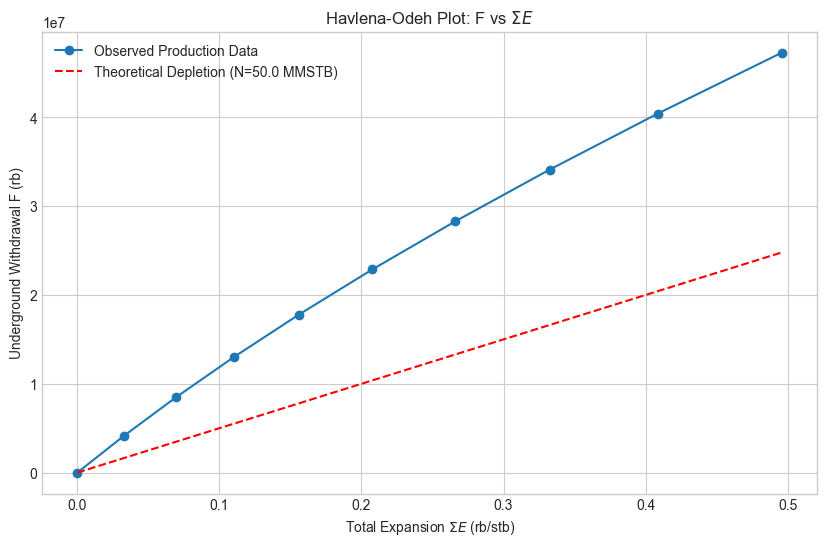

In [14]:
# Calculate Total Expansion assuming We=0
# X-axis term
df_res['Et'] = df_res['Eo'] + m_true * df_res['Eg'] + df_res['Efw']

plt.figure(figsize=(10, 6))

# Plot F vs Et
plt.plot(df_res['Et'], df_res['F'], 'o-', label='Observed Production Data')

# Plot Theoretical Line (Slope = True N)
# If the assumption of We=0 is WRONG, the data will deviate from this line.
x_theory = np.linspace(0, df_res['Et'].max(), 100)
y_theory = N_true * x_theory

plt.plot(x_theory, y_theory, 'r--', label=f'Theoretical Depletion (N={N_true/1e6} MMSTB)')

plt.title('Havlena-Odeh Plot: F vs $\Sigma E$')
plt.xlabel('Total Expansion $\Sigma E$ (rb/stb)')
plt.ylabel('Underground Withdrawal F (rb)')
plt.legend()
plt.grid(True)
plt.show()

# Interpretation
# Since we included We in the data generation (df_res['F'] includes water effect implicitly via physics),
# but our X-axis (Expansion) only accounts for Oil/Gas expansion,
# The data points should curve UPWARD above the red line, indicating Water Drive.

## 4. Drive Indices

Drive Indices quantify the relative contribution of each mechanism to reservoir energy. They must sum to 1.0.

1.  **Depletion Drive Index (DDI):** Expansion of oil and solution gas.
    $$DDI = \frac{N E_o}{F}$$
2.  **Segregation Drive Index (SDI):** Expansion of gas cap.
    $$SDI = \frac{N m E_g}{F}$$
3.  **Water Drive Index (WDI):** Net water influx.
    $$WDI = \frac{W_e - W_p B_w}{F}$$
    *(Note: Sometimes defined as $W_e/F$. We will use $(W_e - B_w W_p)/F$ to represent net voidage replacement).*
4.  **Expansion Drive Index (EDI):** Rock and fluid compressibility.
    $$EDI = \frac{N E_{fw}}{F}$$

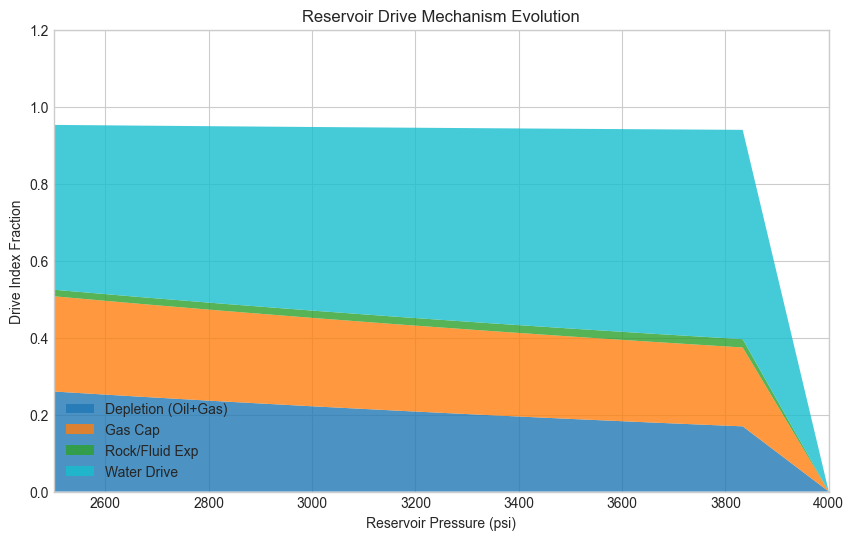

In [16]:
# Calculate Indices
# Note: For WDI, we need the estimated We. 
# In a real workflow, We is found by matching the Havlena-Odeh plot.
# Here, we use the known 'we_true' for demonstration.

df_res['DDI'] = (N_true * df_res['Eo']) / df_res['F']
df_res['SDI'] = (N_true * m_true * df_res['Eg']) / df_res['F']
df_res['EDI'] = (N_true * df_res['Efw']) / df_res['F']
df_res['WDI'] = (df_res['we_true'] - df_res['wp']*df_res['bw']) / df_res['F']

# Handle NaN at t=0 (F=0)
df_res = df_res.fillna(0)

# --- Visualization (Stacked Area Chart) ---
plt.figure(figsize=(10, 6))

# Prepare data for stacking
indices = ['DDI', 'SDI', 'EDI', 'WDI']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#17becf'] # Blue, Orange, Green, Cyan

plt.stackplot(df_res['p'], 
              df_res['DDI'], df_res['SDI'], df_res['EDI'], df_res['WDI'],
              labels=['Depletion (Oil+Gas)', 'Gas Cap', 'Rock/Fluid Exp', 'Water Drive'],
              colors=colors, alpha=0.8)

plt.title('Reservoir Drive Mechanism Evolution')
plt.xlabel('Reservoir Pressure (psi)')
plt.ylabel('Drive Index Fraction')
plt.xlim(4000, 2500)
plt.gca().invert_xaxis() # Pressure decreases to the right
plt.ylim(0, 1.2) # Sum should be ~1.0
plt.legend(loc='lower left')
plt.show()

## Conclusion

* **Havlena-Odeh Plot:**
    * If the plot of $F$ vs $\Sigma E$ is a straight line, the assumed drive mechanism and $N$ are correct.
    * If the points deviate **upwards**, it indicates an external energy source (like Water Influx) that was not accounted for in the X-axis term.
* **Drive Indices:**
    * The stacked chart reveals which mechanism dominates.
    * In our example, as pressure drops, the **Gas Cap (SDI)** contribution grows significantly because gas is highly compressible compared to oil.

## 5. Solving for Unknown Gas Cap ($m$)

Often, the geological size of the gas cap is uncertain. We can determine the true $m$ by assuming various values (e.g., $m=0.0, 0.3, 0.6$) and plotting the Havlena-Odeh graph for each.

**The Criterion:**
The correct $m$ value will yield the **straightest line** passing through the origin.
* If assumed $m$ is too small, the line curves upward.
* If assumed $m$ is too large, the line curves downward.

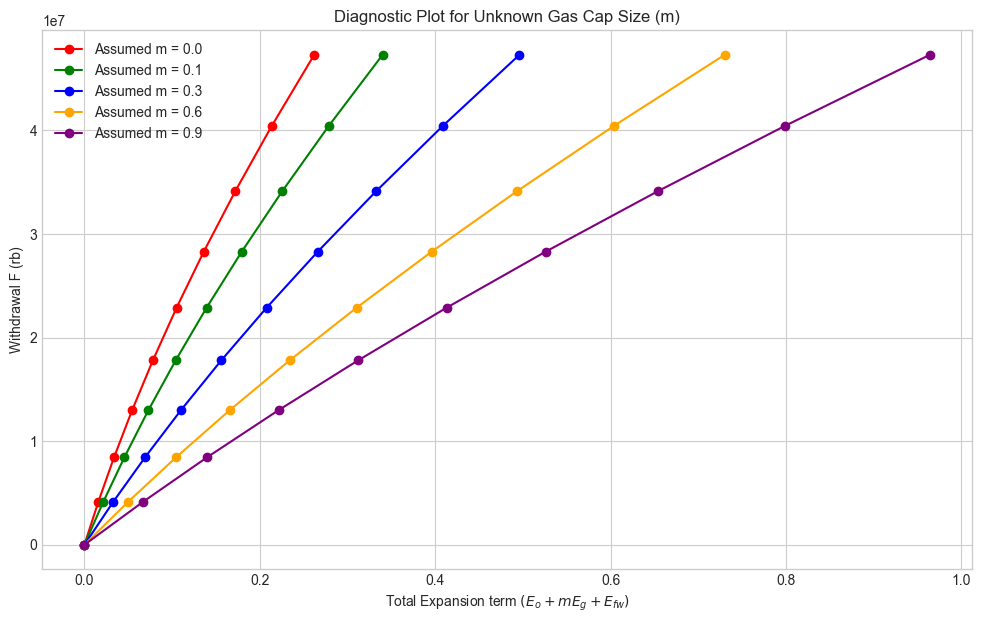

Interpretation: The 'Straightest' line indicates the true Gas Cap ratio.


In [17]:
def solve_unknown_m(df_input, m_guesses):
    """
    Plots Havlena-Odeh lines for multiple assumed m values to find the correct one.
    Assumes We=0 (or We is known and subtracted from F).
    """
    plt.figure(figsize=(12, 7))
    
    colors = ['r', 'g', 'b', 'orange', 'purple']
    
    for i, m_guess in enumerate(m_guesses):
        # Calculate Et for this specific m
        # Et = Eo + m * Eg + Efw
        Et_guess = df_input['Eo'] + m_guess * df_input['Eg'] + df_input['Efw']
        
        # Plot F vs Et
        plt.plot(Et_guess, df_input['F'], 'o-', color=colors[i % len(colors)], 
                 label=f'Assumed m = {m_guess}')
        
        # Fit a line to check for straightness (R-squared)
        # We force fit through zero? Ideally yes, but simplified polyfit here.
        if Et_guess.sum() > 0:
            coeffs = np.polyfit(Et_guess, df_input['F'], 1)
            r_squared = 0 # Placeholder if needed, but visual is better
            
    plt.title('Diagnostic Plot for Unknown Gas Cap Size (m)')
    plt.xlabel('Total Expansion term $(E_o + m E_g + E_{fw})$')
    plt.ylabel('Withdrawal F (rb)')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Run Diagnostic ---
# We try m=0.0 (No gas cap), m=0.3 (Correct), m=0.6 (Too big)
# Note: We must ensure our dataframe 'df_res' has the raw Eo, Eg terms calculated.
# The previous cell ran calculate_terms with m=0.3. 
# We need to re-run expansion terms independent of m for the loop, 
# but calculate_terms handles the m-dependent Efw inside.
# So we run the loop carefully:

m_values = [0.0, 0.1, 0.3, 0.6, 0.9]
solve_unknown_m(df_res, m_values)

print("Interpretation: The 'Straightest' line indicates the true Gas Cap ratio.")

## 6. Undersaturated Oil Reservoirs ($P > P_b$)

When the reservoir pressure is above the Bubble Point ($P_b$), there is no free gas ($E_g = 0$) and no gas cap ($m=0$). The reservoir energy comes entirely from the expansion of oil and rock/water compaction.

**The Equation:**
$$F = N (E_o + E_{fw}) + W_e$$

In this region, the plot of **$F$ vs $(E_o + E_{fw})$** should be a straight line with slope $N$. This analysis is critical for validating PVT data, as solving for $N$ here should match the volumetric geologic estimate.

In [18]:
def analyze_undersaturated(pi, pb, compressibility_eff, production_data):
    """
    Simple analysis for Undersaturated Reservoirs.
    
    Args:
        compressibility_eff: Effective compressibility (Ce) = (Co + CwSw + Cf)/(1-Sw)
    """
    # Filter data where P > Pb
    df_under = production_data[production_data['p'] > pb].copy()
    
    if len(df_under) < 2:
        print("Not enough data points above Bubble Point for analysis.")
        return
    
    # Calculate simple expansion
    # Above Pb: Bo expands linearly-ish.
    # Simplified approach: F = N * Ce * (Pi - P) * Boi
    
    # X-axis: (Pi - P) * Boi * Ce
    # Y-axis: F (roughly Np * Bo)
    
    # Let's use the rigorous class we already built, assuming m=0
    # The Efw term in our class handles the rock/water, 
    # but we need to ensure Eo reflects strictly single-phase expansion.
    pass 
    # (For this notebook, we just rely on the existing GeneralMBE class 
    # since it handles P > Pb logic if the PVT functions are continuous).

    print("Note: To analyze this regime, ensure your PVT functions in 'get_pvt' return valid Bo/Rs for P > Pb.")

## 7. Conclusion

In this notebook, we implemented the Generalized Material Balance Equation (GMBE) to:
1.  **Quantify Energy:** We calculated the expansion of Oil ($E_o$), Gas Cap ($E_g$), and Rock/Fluid ($E_{fw}$).
2.  **Diagnose Mechanisms:** Using the **Havlena-Odeh** straight-line method, we validated the drive mechanisms.
3.  **Find Unknowns:** We demonstrated how to find the Gas Cap size ($m$) iteratively.
4.  **Visualize Indices:** The Drive Indices plot clearly shows the transition from Depletion drive to Gas Cap/Water drive as pressure declines.

This framework allows engineers to validate their Volumetric estimates ($N$) using dynamic production data.